# Import Library

In [64]:
import re
import nltk
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import gensim
from gensim.corpora import Dictionary
from gensim.test.utils import get_tmpfile
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100

# Input Data

In [65]:
data = pd.read_excel('../Skripsi/data.xlsx')
data = pd.DataFrame(data)
data[['text']]

,text
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj..."
...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?"
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2..."
1516,Yaampun omicron udah sampe aja ke kantor ini ?????
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang


# Preprocesing

In [66]:
def filteringText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text) 
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text

def casefoldingText(text): 
    text = text.lower() 
    return text

def tokenizingText(text): 
    text = word_tokenize(text) 
    return text
    
slangWord = pd.read_excel('../Skripsi/kamus_kata_alay.xlsx')

slangWord_dict = {}

for index, row in slangWord.iterrows():
    if row[0] not in slangWord_dict:
        slangWord_dict[row[0]] = row[1]
        
def slangWordText(text):
    text = [slangWord_dict[term] if term in slangWord_dict else term for term in text]
    return text

def stopwordRemovalText(text): 
    factory = StopWordRemoverFactory()
    stopword = factory.get_stop_words()
    kata = ['sih', 'ya', 'hahaha', 'terus', 'tt', 'jadi', 'lah', 'gue', 'dulu', 'kok', 'an', 'nya', 'e','kan','lo','per', 'ba', 'lu', 'gp', 'si', 'bor', 'ah', 'tak']
    stopword.extend(kata)
    text = [word for word in text if word not in stopword]
    return text



## Case Folding

In [67]:
#Case Folding
data['preprocessing'] = data['text'].apply(casefoldingText)
data[['text', 'preprocessing']]

,text,preprocessing
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,@papagomol123 @cintahati03 @d34ftone @addien90s vaksin lain tak sama bro mcm vaksin covid. aku t...
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,@nomvelvetshidae aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,@sasisudibyo dulu mungkin imunisasinya diinstallin anti virus smadav. baru covid ini yang disuntik.
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,@arifbsantoso @pbidi tolong idi mulai data jumlah kasus dbd tahun ini dan stop fokus sama kasus ...
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...","@iyasayariyan @ridwanhr gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj..."
...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?","ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?"
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...","seberapa parah omicron ini?\n\ndgn tools sederhana googletrend, dan membandingkan periode peak 2..."
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,yaampun omicron udah sampe aja ke kantor ini ?????
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang


## Filtering

In [68]:
#Filtering
data['preprocessing'] = data['preprocessing'].apply(filteringText)
data[['text', 'preprocessing']]

,text,preprocessing
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,vaksin lain tak sama bro mcm vaksin covid aku tanya pasal kesan sampingan bukan tujuan vaksin co...
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,aku langsung kepikiran sama rv gara pada kena covid lagi itu orang
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,dulu mungkin imunisasinya diinstallin anti virus smadav baru covid ini yang disuntik
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,tolong idi mulai data jumlah kasus dbd tahun ini dan stop fokus sama kasus wuhan covid sekarang...
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...",gtw gua gedek semenjak covid malah isinya kok pamer pamer berkedok kerja keras pamer aja lah nga...
...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?",ini nih omicron kayaknya siapa aja gampang banget kenanya stay safe everyone
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...",seberapa parah omicron ini dgn tools sederhana googletrend dan membandingkan periode peak nd wa...
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,yaampun omicron udah sampe aja ke kantor ini
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang


## Tokenisasi

In [69]:
#Tokenisasi
data['preprocessing'] = data['preprocessing'].apply(tokenizingText)
data[['text', 'preprocessing']]

,text,preprocessing
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,"[vaksin, lain, tak, sama, bro, mcm, vaksin, covid, aku, tanya, pasal, kesan, sampingan, bukan, t..."
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,"[aku, langsung, kepikiran, sama, rv, gara, pada, kena, covid, lagi, itu, orang]"
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,"[dulu, mungkin, imunisasinya, diinstallin, anti, virus, smadav, baru, covid, ini, yang, disuntik]"
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,"[tolong, idi, mulai, data, jumlah, kasus, dbd, tahun, ini, dan, stop, fokus, sama, kasus, wuhan,..."
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...","[gtw, gua, gedek, semenjak, covid, malah, isinya, kok, pamer, pamer, berkedok, kerja, keras, pam..."
...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?","[ini, nih, omicron, kayaknya, siapa, aja, gampang, banget, kenanya, stay, safe, everyone]"
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...","[seberapa, parah, omicron, ini, dgn, tools, sederhana, googletrend, dan, membandingkan, periode,..."
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,"[yaampun, omicron, udah, sampe, aja, ke, kantor, ini]"
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,"[mending, pcr, kalo, parah, dar, omicron, susah, dideteksi, kalo, antigen, doang]"


## Normalisasi

In [70]:
#Normalisasi
data['preprocessing'] = data['preprocessing'].apply(slangWordText)
data[['text', 'preprocessing']]

,text,preprocessing
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,"[vaksin, lain, tak, sama, bro, macam, vaksin, covid, aku, tanya, pasal, kesan, sampingan, bukan,..."
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,"[aku, langsung, kepikiran, sama, rv, gara, pada, kena, covid, lagi, itu, orang]"
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,"[dulu, mungkin, imunisasinya, diinstallin, anti, virus, smadav, baru, covid, ini, yang, disuntik]"
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,"[tolong, idi, mulai, data, jumlah, kasus, dbd, tahun, ini, dan, stop, fokus, sama, kasus, wuhan,..."
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...","[enggak tau, gua, gedek, semenjak, covid, malah, isinya, kok, pamer, pamer, berkedok, kerja, ker..."
...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?","[ini, nih, omicron, kayaknya, siapa, saja, gampang, banget, kenanya, stay, safe, everyone]"
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...","[seberapa, parah, omicron, ini, dengan, tools, sederhana, googletrend, dan, membandingkan, perio..."
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,"[yaampun, omicron, sudah, sampai, saja, ke, kantor, ini]"
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,"[mending, pcr, kalau, parah, dar, omicron, susah, dideteksi, kalau, antigen, doang]"


## Stopword Removal

In [71]:
#Stopword Removal
data['preprocessing'] = data['preprocessing'].apply(stopwordRemovalText)
data[['text', 'preprocessing']]

,text,preprocessing
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,"[vaksin, sama, bro, macam, vaksin, covid, aku, tanya, pasal, kesan, sampingan, bukan, tujuan, va..."
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,"[aku, langsung, kepikiran, sama, rv, gara, kena, covid, orang]"
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,"[mungkin, imunisasinya, diinstallin, anti, virus, smadav, baru, covid, disuntik]"
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,"[idi, mulai, data, jumlah, kasus, dbd, tahun, stop, fokus, sama, kasus, wuhan, covid, sekarang, ..."
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...","[enggak tau, gua, gedek, semenjak, covid, malah, isinya, pamer, pamer, berkedok, kerja, keras, p..."
...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?","[nih, omicron, kayaknya, siapa, gampang, banget, kenanya, stay, safe, everyone]"
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...","[seberapa, parah, omicron, tools, sederhana, googletrend, membandingkan, periode, peak, indak, w..."
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,"[yaampun, omicron, kantor]"
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,"[mending, pcr, kalau, parah, dar, omicron, susah, dideteksi, kalau, antigen, doang]"


# Ekstraksi Aspek Menggunakan Latent Dirichlet Allocation (LDA)

In [72]:
doc_clean = data['preprocessing']

dictionary = Dictionary(doc_clean)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean] 

In [73]:
coherence = []
for k in range(1,11):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary,  passes=50, iterations=100, chunksize=1519, eval_every=None)
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=doc_clean,
                                                     dictionary=dictionary, coherence='c_v')

    coherence.append((k,cm.get_coherence()))

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10


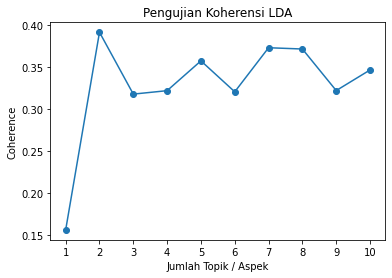

In [74]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Pengujian Koherensi LDA')
plt.xlabel('Jumlah Topik / Aspek')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [85]:
print(coherence)

[(1, 0.1561293637250662), (2, 0.3914635288582271), (3, 0.31780509529829587), (4, 0.32191271721010767), (5, 0.3573963119330964), (6, 0.3205529651358398), (7, 0.3730199462276289), (8, 0.3715051655328756), (9, 0.3220234644662662), (10, 0.3465493061798953)]


In [75]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

total_topics = 2 # jumlah topik yang akan di extract
number_words = 10 # jumlah kata per topik

# Running and Trainign LDA model on the document term matrix.
lda_model = Lda(doc_term_matrix, 
            num_topics=total_topics, 
            id2word = dictionary, 
            chunksize=1519,
            passes=50,
            iterations=100,
            eval_every=None,
            random_state=None)
# Word Count of Topic Keywords

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_imp_wcount = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
#df_imp_wcount

#Dominant topic and its percentage contribution in each topic
document = data['preprocessing']

def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=document):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=doc_clean)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

pyLDAvis.enable_notebook()
topic_data =  gensimvis.prepare(lda_model, doc_term_matrix, dictionary, mds = 'pcoa')

    
dataLDA = data['aspek'] = df_dominant_topic['Dominant_Topic']

data_LDA = data

In [76]:
all_topics = {}
lambd = 0.6# Adjust this accordingly
for i in range(1,total_topics+1): #Adjust number of topics in final model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values
    
pd.DataFrame(all_topics)

,Topic 1,Topic 2
0,covid,omicron
1,omicron,negeri
2,enggak,bersama
3,kena,membangun
4,banget,varian
5,orang,kasus
6,kalau,ppkm
7,semua,pemerintah
8,sama,penyebaran
9,hari,luar


In [77]:
data['aspek'] = data['aspek'].map({ 0 :'covid', 
                             1 : 'omicron'},
                            na_action=None)

data[['text', 'preprocessing', 'aspek']]

,text,preprocessing,aspek
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,"[vaksin, sama, bro, macam, vaksin, covid, aku, tanya, pasal, kesan, sampingan, bukan, tujuan, va...",omicron
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,"[aku, langsung, kepikiran, sama, rv, gara, kena, covid, orang]",omicron
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,"[mungkin, imunisasinya, diinstallin, anti, virus, smadav, baru, covid, disuntik]",covid
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,"[idi, mulai, data, jumlah, kasus, dbd, tahun, stop, fokus, sama, kasus, wuhan, covid, sekarang, ...",omicron
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...","[enggak tau, gua, gedek, semenjak, covid, malah, isinya, pamer, pamer, berkedok, kerja, keras, p...",omicron
...,...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?","[nih, omicron, kayaknya, siapa, gampang, banget, kenanya, stay, safe, everyone]",omicron
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...","[seberapa, parah, omicron, tools, sederhana, googletrend, membandingkan, periode, peak, indak, w...",covid
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,"[yaampun, omicron, kantor]",omicron
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,"[mending, pcr, kalau, parah, dar, omicron, susah, dideteksi, kalau, antigen, doang]",omicron


omicron    892
covid      627
Name: aspek, dtype: int64


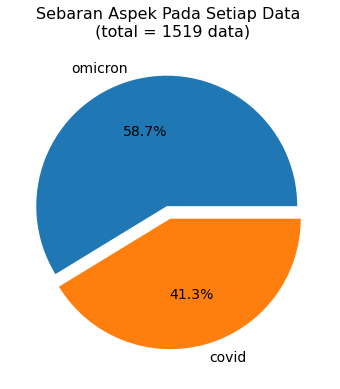

In [78]:
#pd.DataFrame(all_topics)
print(data['aspek'].value_counts())
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in data['aspek'].value_counts()]
labels = list(data['aspek'].value_counts().index)
explode = (0.1, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sebaran Aspek Pada Setiap Data \n (total = 1519 data)', fontsize = 16, pad = 20)
plt.show() 

# Pelabelan Otomatis Menggunakan Inset Lexicon

In [79]:
lexicon_positive = pd.read_excel('../Skripsi/kamus_positive.xlsx')
lexicon_positive_dict = {}
for index, row in lexicon_positive.iterrows():
    if row[0] not in lexicon_positive_dict:
        lexicon_positive_dict[row[0]] = row[1]

lexicon_negative = pd.read_excel('../Skripsi/kamus_negative.xlsx')
lexicon_negative_dict = {}
for index, row in lexicon_negative.iterrows():
    if row[0] not in lexicon_negative_dict:
        lexicon_negative_dict[row[0]] = row[1]

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive_dict):
            score = score + lexicon_positive_dict[word]
    for word in text:
        if (word in lexicon_negative_dict):
            score = score + lexicon_negative_dict[word]
    sentimen=''
    if (score > 0):
        sentimen = 'positif'
    elif (score < 0):
        sentimen = 'negatif'
    else:
        sentimen = 'netral'
    return score, sentimen
    
results = data['preprocessing'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
data['score_sentimen'] = results[0]
#data['sentimen'] = results[1]
#data

data['score_sentimen'] = results[1]
dataSentimen = data.rename(columns = { 'score_sentimen': 'sentimen_inset' }, inplace=True)
data_inset = data

data_inset[['text', 'preprocessing', 'aspek', 'sentimen_inset']]

,text,preprocessing,aspek,sentimen_inset
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,"[vaksin, sama, bro, macam, vaksin, covid, aku, tanya, pasal, kesan, sampingan, bukan, tujuan, va...",omicron,negatif
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,"[aku, langsung, kepikiran, sama, rv, gara, kena, covid, orang]",omicron,netral
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,"[mungkin, imunisasinya, diinstallin, anti, virus, smadav, baru, covid, disuntik]",covid,negatif
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,"[idi, mulai, data, jumlah, kasus, dbd, tahun, stop, fokus, sama, kasus, wuhan, covid, sekarang, ...",omicron,negatif
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...","[enggak tau, gua, gedek, semenjak, covid, malah, isinya, pamer, pamer, berkedok, kerja, keras, p...",omicron,negatif
...,...,...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?","[nih, omicron, kayaknya, siapa, gampang, banget, kenanya, stay, safe, everyone]",omicron,negatif
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...","[seberapa, parah, omicron, tools, sederhana, googletrend, membandingkan, periode, peak, indak, w...",covid,negatif
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,"[yaampun, omicron, kantor]",omicron,netral
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,"[mending, pcr, kalau, parah, dar, omicron, susah, dideteksi, kalau, antigen, doang]",omicron,negatif


# Pengujian Akurasi

In [80]:
data_uji = pd.read_excel('../Skripsi/data_uji.xlsx')
data_uji = pd.DataFrame(data_uji)
display(data_uji)

,text,aspek_manual,sentimen
0,@papagomol123 @cintahati03 @d34ftone @addien90s Vaksin lain tak sama bro mcm vaksin covid. Aku t...,omicron,negatif
1,@nomvelvetshidae Aku langsung kepikiran sama rv gara' pada kena covid lagi itu orang' ???,omicron,netral
2,@sasisudibyo Dulu mungkin imunisasinya diinstallin Anti Virus SMADAV. Baru Covid ini yang disuntik.,omicron,negatif
3,@arifbsantoso @PBIDI Tolong IDI mulai data jumlah kasus DBD tahun ini dan stop fokus sama kasus ...,omicron,negatif
4,"@iyasayariyan @ridwanhr Gtw gua gedek semenjak covid, malah isinya kok pamer pamer berkedok kerj...",omicron,negatif
...,...,...,...
1514,"ini nih omicron kayaknya siapa aja gampang banget kenanya, stay safe everyone?",omicron,negatif
1515,"Seberapa parah Omicron ini?\n\nDgn tools sederhana GoogleTrend, dan membandingkan periode peak 2...",covid,negatif
1516,Yaampun omicron udah sampe aja ke kantor ini ?????,omicron,negatif
1517,@darderdork mending pcr kalo parah dar omicron susah dideteksi kalo antigen doang,omicron,negatif


In [81]:
data['aspek_sentimen'] = data['aspek'] + " " + data['sentimen']
data['aspek_sentimen_inset'] = data['aspek'] + " " + data['sentimen_inset']

aspek_covid   = data[data['aspek'] == 'covid']
aspek_omicron = data[data['aspek'] == 'omicron']

In [82]:
print('Pengujian Akurasi Pelabelan Aspek')
print(classification_report(data['aspek'], data['aspek_manual']))

print('nilai akurasinya adalah ',accuracy_score(data['aspek'], data['aspek_manual']))

print(confusion_matrix(data['aspek'], data['aspek_manual']))

Pengujian Akurasi Pelabelan Aspek
              precision    recall  f1-score   support

       covid       0.69      0.80      0.74       627
     omicron       0.84      0.74      0.79       892

    accuracy                           0.77      1519
   macro avg       0.77      0.77      0.77      1519
weighted avg       0.78      0.77      0.77      1519

nilai akurasinya adalah  0.7682685977616853
[[503 124]
 [228 664]]


In [83]:
print('Pengujian Akurasi Sentimen Aspek Covid')
print(classification_report(aspek_covid['aspek_sentimen_inset'], aspek_covid['aspek_sentimen']))

print('nilai akurasinya adalah ',accuracy_score(aspek_covid['aspek_sentimen_inset'], aspek_covid['aspek_sentimen']))

print(confusion_matrix(aspek_covid['aspek_sentimen_inset'], aspek_covid['aspek_sentimen']))

Pengujian Akurasi Sentimen Aspek Covid
               precision    recall  f1-score   support

covid negatif       0.90      0.95      0.92       273
 covid netral       0.80      0.77      0.78       111
covid positif       0.91      0.88      0.90       243

     accuracy                           0.89       627
    macro avg       0.87      0.86      0.87       627
 weighted avg       0.89      0.89      0.89       627

nilai akurasinya adalah  0.8883572567783095
[[258   6   9]
 [ 15  85  11]
 [ 14  15 214]]


In [84]:
print('Pengujian Akurasi Sentimen  Aspek Omicron')
print(classification_report(aspek_omicron['aspek_sentimen_inset'], aspek_omicron['aspek_sentimen']))

print('nilai akurasinya adalah ',accuracy_score(aspek_omicron['aspek_sentimen_inset'], aspek_omicron['aspek_sentimen']))

print(confusion_matrix(aspek_omicron['aspek_sentimen_inset'], aspek_omicron['aspek_sentimen']))

Pengujian Akurasi Sentimen  Aspek Omicron
                 precision    recall  f1-score   support

omicron negatif       0.90      0.91      0.91       665
 omicron netral       0.62      0.70      0.65        69
omicron positif       0.64      0.56      0.59       158

       accuracy                           0.83       892
      macro avg       0.72      0.72      0.72       892
   weighted avg       0.83      0.83      0.83       892

nilai akurasinya adalah  0.8340807174887892
[[608  12  45]
 [ 16  48   5]
 [ 52  18  88]]
